# Imports CIFAR-100

In [ ]:
#https://github.com/pytorch/tutorials/blob/main/beginner_source/fgsm_tutorial.py
import os
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Attack Coefficients CIFAR-100

In [ ]:
#https://github.com/pytorch/tutorials/blob/main/beginner_source/fgsm_tutorial.py
# pretrained_modelis the same as the tutorial's pretrained_model

# Pick Any seed integer
torch.manual_seed(42)

#Changed Values
epsilons = [0, .001, .002, .03, .05, .15, .3]

# Path to the downloaded model file
pretrained_model = "data/lenet_mnist_model.pth.pt"
use_cuda = True

# Model CIFAR-100

In [ ]:
# Define what device we are using
# https://github.com/pytorch/tutorials/blob/main/beginner_source/fgsm_tutorial.py
# https://stackoverflow.com/questions/63302534/how-to-write-torch-devicecuda-if-torch-cuda-is-available-else-cpu-as-a-f
# https://stackoverflow.com/questions/67302634/how-do-i-load-a-local-model-with-torch-hub-load
cuda_available = torch.cuda.is_available()
if use_cuda and cuda_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("CUDA Available:", cuda_available)

# https://github.com/chenyaofo/pytorch-cifar-models
# https://pytorch.org/tutorials/beginner/saving_loading_models.html?highlight=eval
# https://pytorch.org/hub/pytorch_vision_resnet/
# https://pytorch.org/hub/#:~:text=Users%20can%20load%20pre-trained%20models%20using%20torch.hub.load%28%29%20API.,the%20pytorch%2Fvision%20repo.%20model%20%3D%20torch.hub.load%28%27pytorch%2Fvision%27%2C%20%27resnet18%27%2C%20pretrained%3DTrue%29
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_repvgg_a2", pretrained=True)
model.eval()

CUDA Available: True


/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/repvgg/cifar100_repvgg_a2-8e71b1f8.pt" to /root/.cache/torch/hub/checkpoints/cifar100_repvgg_a2-8e71b1f8.pt
100%|██████████| 103M/103M [00:02<00:00, 43.5MB

RepVGG(
  (stage0): RepVGGBlock(
    (nonlinearity): ReLU()
    (rbr_dense): Sequential(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (rbr_1x1): Sequential(
      (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): Sequential(
    (0): RepVGGBlock(
      (nonlinearity): ReLU()
      (rbr_dense): Sequential(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (rbr_1x1): Sequential(
        (conv): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
 

# CIFAR100 DataSet

In [ ]:
# https://cdn.jsdelivr.net/gh/chenyaofo/pytorch-cifar-models@logs/logs/cifar100/repvgg_a2/default.log
# The Log of how this DataSet was trained shows the values for the mean and std
# https://github.com/chenyaofo/pytorch-cifar-models
# Normalization Function
# Standard deviation is std
mean = (0.507, 0.4865, 0.4409)
std = (0.2673, 0.2564, 0.2761)

# Create CIFAR-100 test data loader with normalization
#https://pytorch.org/vision/main/_modules/torchvision/transforms/transforms.html#Normalize
normalize = transforms.Normalize(mean=mean, std=std)

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])


# Use CIFAR-100 test dataset
cifar_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loader for CIFAR-10 test dataset
cifar_test_loader = torch.utils.data.DataLoader(
    dataset=cifar_test_dataset,
    batch_size=1,
    shuffle=True
)

100%|██████████| 170498071/170498071 [00:03<00:00, 48760701.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# Tutorial's FGSM Attack

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

# Test the network on the test data

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data, list(mean), list(std))

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize(mean, std)(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

# Output Attack Graph

In [ ]:
# Assuming 'device' is already defined as 'torch.device("cuda" if torch.cuda.is_available() else "cpu")'

# Move the model to the GPU
model.to(device)

# Continue with the rest of your code...
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model=model, device=device, test_loader=cifar_test_loader, epsilon=eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 65 / 10000 = 0.0065
Epsilon: 0.001	Test Accuracy = 14 / 10000 = 0.0014
Epsilon: 0.002	Test Accuracy = 4 / 10000 = 0.0004
Epsilon: 0.03	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.05	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.15	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 10000 = 0.0


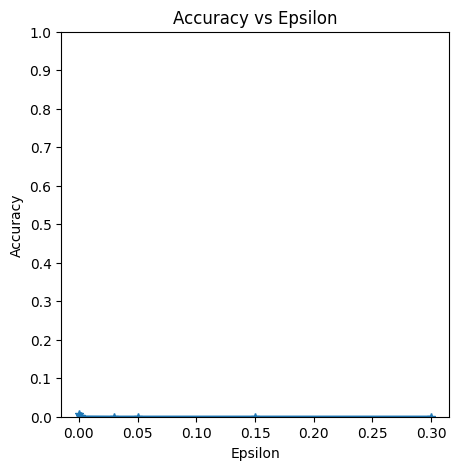

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

# Output Attack Images

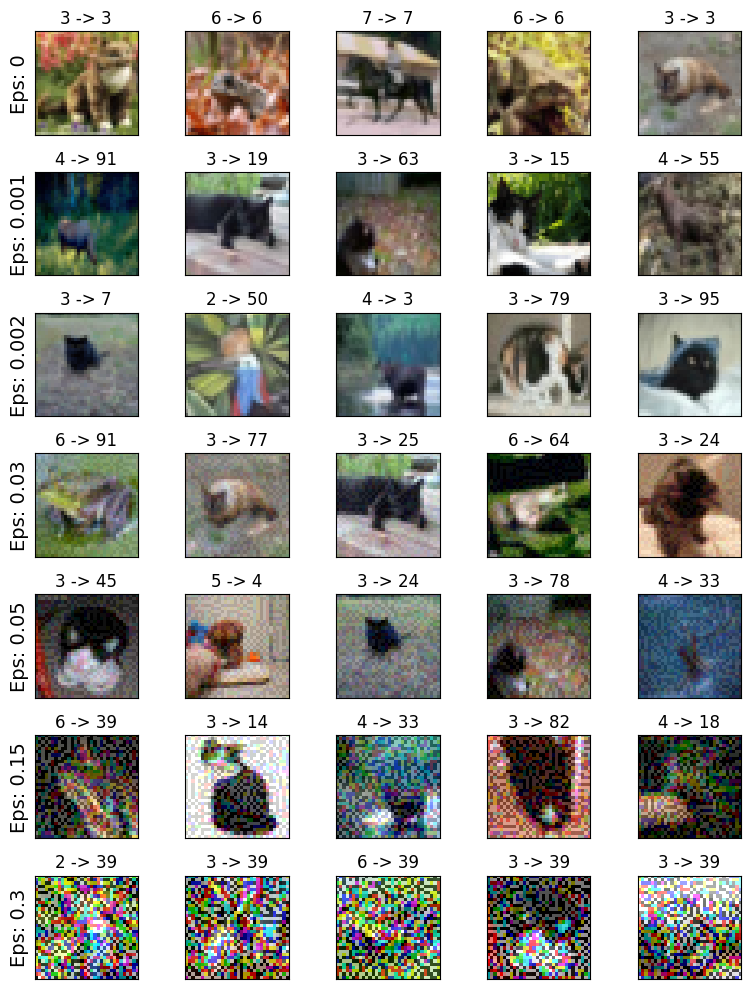

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex.transpose(1, 2, 0))
plt.tight_layout()
plt.show()